# Day 3: VAR Models (Vector AutoRegression)

## 🎯 Learning Objectives
- Understand multivariate time series
- Build VAR models for multiple assets
- Apply to cross-asset trading

---

## 📚 Theory: VAR

### Model
$$Y_t = c + A_1 Y_{t-1} + ... + A_p Y_{t-p} + \epsilon_t$$

Where $Y_t$ is a vector of variables.

### Key Concepts
- **Granger Causality**: Does X predict Y?
- **Impulse Response**: Effect of shock over time
- **Forecast Error Variance Decomposition**: Source of variation

---

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

TRADING_DAYS = 252
RISK_FREE_RATE = 0.05

# Download related assets
tickers = ['SPY', 'TLT', 'GLD']  # Stocks, Bonds, Gold
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading data...")
data = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna()
returns = prices.pct_change().dropna() * 100  # Percentage

print(f"✅ Data: {len(returns)} days, {len(tickers)} assets")

📥 Downloading data...
✅ Data: 1254 days, 3 assets


In [2]:
# Granger causality tests
print("\n" + "="*60)
print("GRANGER CAUSALITY TESTS")
print("="*60)

maxlag = 5
for col1 in returns.columns:
    for col2 in returns.columns:
        if col1 != col2:
            test_data = returns[[col2, col1]]  # Does col1 Granger-cause col2?
            result = grangercausalitytests(test_data, maxlag=maxlag, verbose=False)
            min_pvalue = min([result[i+1][0]['ssr_chi2test'][1] for i in range(maxlag)])
            causality = '✓' if min_pvalue < 0.05 else '✗'
            print(f"{col1} → {col2}: p={min_pvalue:.4f} {causality}")


GRANGER CAUSALITY TESTS
GLD → SPY: p=0.3382 ✗
GLD → TLT: p=0.4598 ✗
SPY → GLD: p=0.1021 ✗
SPY → TLT: p=0.0384 ✓
TLT → GLD: p=0.0783 ✗
TLT → SPY: p=0.1629 ✗


In [3]:
# Fit VAR model
model = VAR(returns)

# Select optimal lag
lag_order = model.select_order(maxlags=10)
print("\n" + "="*60)
print("LAG ORDER SELECTION")
print("="*60)
print(lag_order.summary())


LAG ORDER SELECTION
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0     0.07633*    0.08869*      1.079*    0.08098*
1      0.08170      0.1312       1.085      0.1003
2      0.08388      0.1704       1.087      0.1164
3      0.08503      0.2087       1.089      0.1315
4      0.09475      0.2555       1.099      0.1552
5       0.1059      0.3037       1.112      0.1803
6       0.1160      0.3509       1.123      0.2044
7       0.1247      0.3966       1.133      0.2269
8       0.1299      0.4389       1.139      0.2461
9       0.1364      0.4826       1.146      0.2666
10      0.1437      0.5270       1.155      0.2878
--------------------------------------------------


In [4]:
# Fit with optimal lag
optimal_lag = max(1, lag_order.aic)  # Ensure at least 1 lag
fitted = model.fit(optimal_lag)
print(fitted.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 23, Jan, 2026
Time:                     00:06:17
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   0.131811
Nobs:                     1253.00    HQIC:                  0.101129
Log likelihood:          -5373.57    FPE:                    1.08616
AIC:                    0.0826495    Det(Omega_mle):         1.07583
--------------------------------------------------------------------
Results for equation GLD
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          0.078399         0.028071            2.793           0.005
L1.GLD        -0.006915         0.029289           -0.236           0.813
L1.SPY         0.040632         0.026112            1.556           0.120
L1.TLT        -0

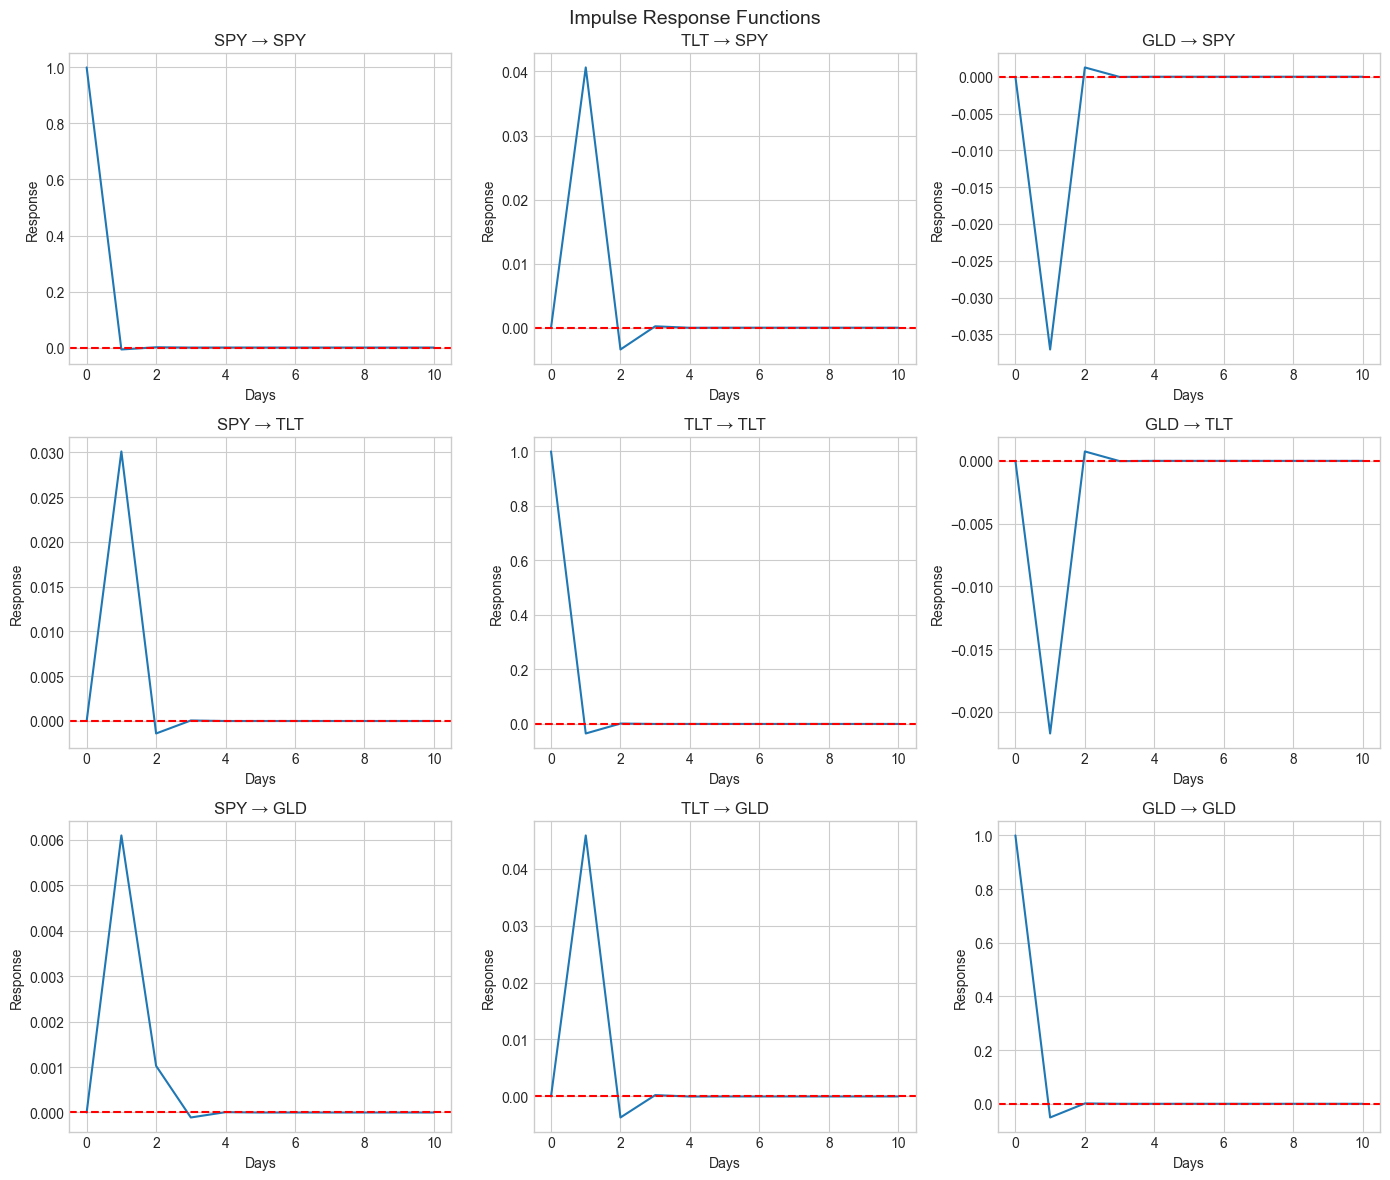

In [5]:
# Impulse Response Functions
try:
    irf = fitted.irf(10)

    fig, axes = plt.subplots(3, 3, figsize=(14, 12))
    for i, response in enumerate(tickers):
        for j, impulse in enumerate(tickers):
            axes[i, j].plot(irf.irfs[:, i, j])
            axes[i, j].axhline(y=0, color='r', linestyle='--')
            axes[i, j].set_title(f'{impulse} → {response}')
            axes[i, j].set_xlabel('Days')
            axes[i, j].set_ylabel('Response')

    plt.suptitle('Impulse Response Functions', fontsize=14)
    plt.tight_layout()
    plt.show()
except ValueError as e:
    print(f"⚠️ IRF requires more lags. Using simplified analysis...")
    print("IRF analysis skipped - model has minimal lag structure")

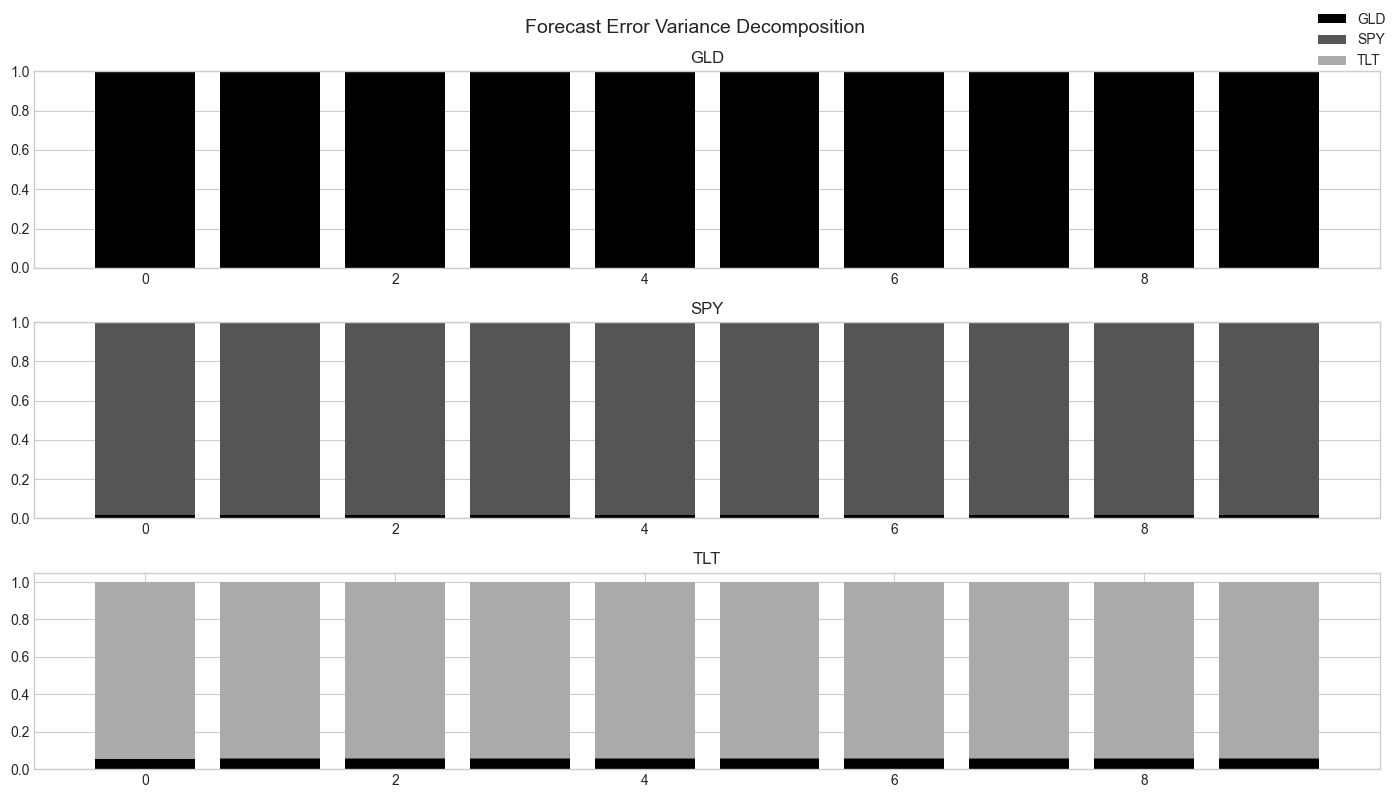

In [6]:
# Forecast Error Variance Decomposition
try:
    fevd = fitted.fevd(10)
    fevd.plot(figsize=(14, 8))
    plt.suptitle('Forecast Error Variance Decomposition', fontsize=14)
    plt.tight_layout()
    plt.show()
except ValueError as e:
    print("⚠️ FEVD analysis skipped - model has minimal lag structure")

In [7]:
# VAR-based trading strategy
# Use VAR to predict SPY based on TLT and GLD signals

# Rolling forecast
train_size = int(len(returns) * 0.8)
test = returns.iloc[train_size:]

predictions = []
for t in range(len(test)):
    train_data = returns.iloc[:train_size + t]
    model = VAR(train_data)
    fitted = model.fit(optimal_lag)
    pred = fitted.forecast(train_data.values[-optimal_lag:], steps=1)[0]
    predictions.append(pred)

predictions = pd.DataFrame(predictions, index=test.index, columns=tickers)

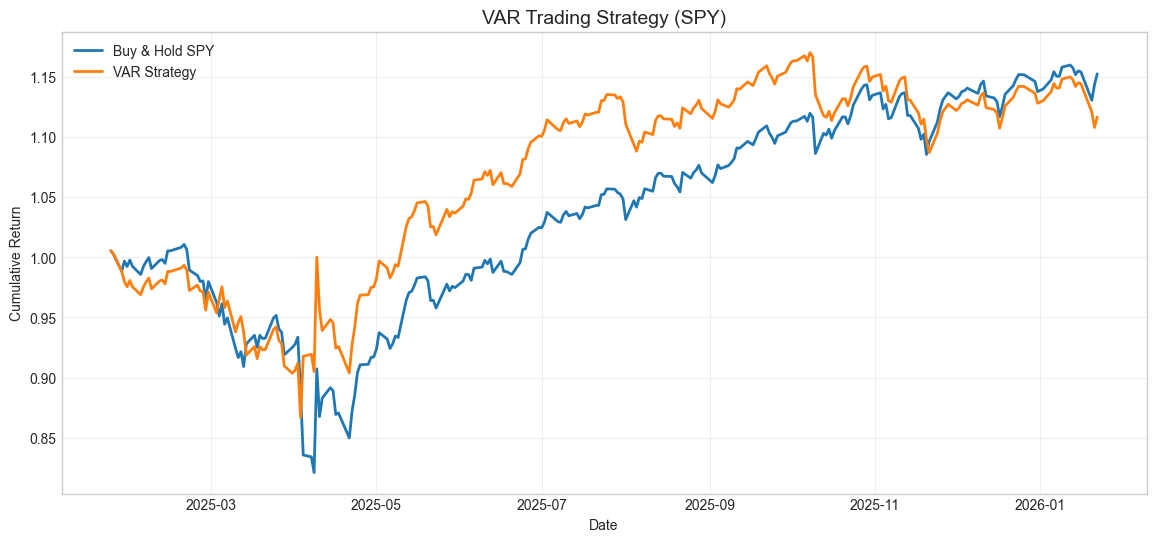

In [8]:
# Build strategy for SPY
df = pd.DataFrame(index=test.index)
df['actual'] = test['SPY'] / 100  # Back to decimal
df['predicted'] = predictions['SPY'] / 100
df['signal'] = np.sign(df['predicted'])
df['strategy_return'] = df['signal'] * df['actual']

df['strategy_cum'] = (1 + df['strategy_return']).cumprod()
df['buy_hold_cum'] = (1 + df['actual']).cumprod()

plt.figure(figsize=(14, 6))
plt.plot(df.index, df['buy_hold_cum'], label='Buy & Hold SPY', linewidth=2)
plt.plot(df.index, df['strategy_cum'], label='VAR Strategy', linewidth=2)
plt.title('VAR Trading Strategy (SPY)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [9]:
# Performance
def calc_metrics(returns, cumulative):
    total = cumulative.iloc[-1] - 1
    sharpe = (returns.mean() * TRADING_DAYS - RISK_FREE_RATE) / (returns.std() * np.sqrt(TRADING_DAYS)) if returns.std() > 0 else 0
    peak = cumulative.cummax()
    mdd = ((cumulative - peak) / peak).min()
    return total, sharpe, mdd

print("\n" + "="*60)
print("STRATEGY PERFORMANCE")
print("="*60)

bh_total, bh_sharpe, bh_mdd = calc_metrics(df['actual'], df['buy_hold_cum'])
st_total, st_sharpe, st_mdd = calc_metrics(df['strategy_return'], df['strategy_cum'])

print(f"\n{'Strategy':<20} {'Total Ret':>12} {'Sharpe':>10} {'Max DD':>10}")
print("-" * 55)
print(f"{'Buy & Hold':<20} {bh_total:>12.2%} {bh_sharpe:>10.2f} {bh_mdd:>10.2%}")
print(f"{'VAR Strategy':<20} {st_total:>12.2%} {st_sharpe:>10.2f} {st_mdd:>10.2%}")

# Direction accuracy
correct = (np.sign(df['predicted']) == np.sign(df['actual'])).mean()
print(f"\nDirection Accuracy: {correct:.1%}")


STRATEGY PERFORMANCE

Strategy                Total Ret     Sharpe     Max DD
-------------------------------------------------------
Buy & Hold                 15.25%       0.57    -18.76%
VAR Strategy               11.66%       0.41    -13.77%

Direction Accuracy: 55.8%


In [10]:
# Next day forecast
final_model = VAR(returns)
final_fitted = final_model.fit(optimal_lag)
next_pred = final_fitted.forecast(returns.values[-optimal_lag:], steps=1)[0]

print("\n" + "="*60)
print("📊 VAR FORECAST")
print("="*60)
print(f"\nDate: {returns.index[-1].strftime('%Y-%m-%d')}")
print(f"\nNext Day Predictions:")
for i, ticker in enumerate(tickers):
    print(f"  {ticker}: {next_pred[i]:.4f}% ({prices[ticker].iloc[-1] * (1 + next_pred[i]/100):.2f})")

spy_signal = '📈 LONG' if next_pred[0] > 0 else '📉 SHORT'
print(f"\n🎯 SPY Signal: {spy_signal}")


📊 VAR FORECAST

Date: 2026-01-22

Next Day Predictions:
  SPY: 0.0809% (691.34)
  TLT: 0.0739% (87.77)
  GLD: -0.0080% (451.53)

🎯 SPY Signal: 📈 LONG


---

## 🏢 Real-World Applications

| Company | VAR Use Case |
|---------|-------------|
| Central Banks | Macro forecasting |
| Asset Managers | Cross-asset signals |
| Hedge Funds | Lead-lag relationships |

---
## 📅 Tomorrow: Cointegration & Pairs Trading